In [5]:
import math 

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import pylab as plt
from sklearn import datasets

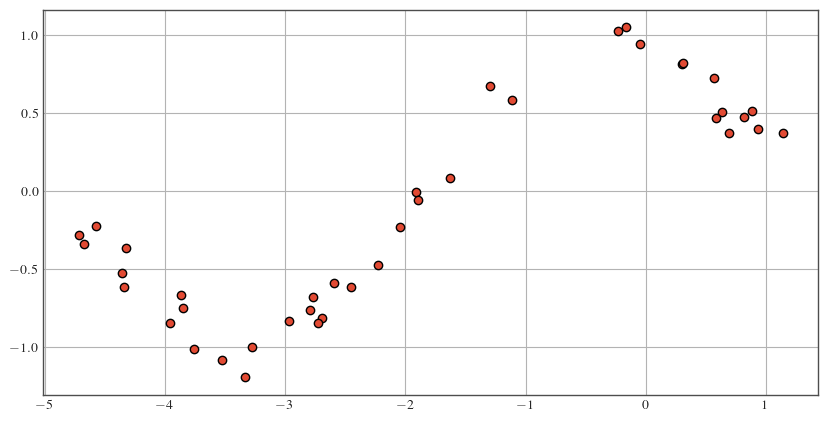

In [6]:
# X, y = datasets.make_moons(200, ) = 
X = torch.Tensor(40, 1).uniform_(-3, 3).float()
y = torch.sin(X).float()
y = y + torch.randn_like(y)*.1

X = (X - X.std(0)) - X.mean(0)
train_ds = torch.utils.data.TensorDataset(X, y)

plt.scatter(X.squeeze(), y)
plt.show()

In [7]:
from dal_toolbox.models.utils.vi import BayesianLinear, BayesianConv2d

class Net(nn.Module):
    def __init__(self, prior_sigma=1) -> None:
        super().__init__()
        self.l1 = BayesianLinear(1, 50, prior_sigma=prior_sigma)
        self.l3 = BayesianLinear(50, 1, prior_sigma=prior_sigma)
        self.act = nn.Tanh()
    
    def forward(self, x):
        out = self.l1(x)
        out = self.act(out)
        # out = self.l2(out)
        # kout = self.act(out)
        out = self.l3(out)
        return out

Epoch [1] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.5574 (4.5574) nll: 0.8541 (0.8541) kl_loss: 3.7033 (3.7033) acc1: 100.0000 (100.0000) time: 0.0372 data: 0.0350 max mem: 0
Epoch [1] Total time: 0:00:00
Epoch [2] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.2069 (4.2069) nll: 0.5036 (0.5036) kl_loss: 3.7033 (3.7033) acc1: 100.0000 (100.0000) time: 0.0016 data: 0.0002 max mem: 0
Epoch [2] Total time: 0:00:00
Epoch [3] [0/2] eta: 0:00:00 lr: 0.1 loss: 3.8626 (3.8626) nll: 0.1594 (0.1594) kl_loss: 3.7032 (3.7032) acc1: 100.0000 (100.0000) time: 0.0016 data: 0.0002 max mem: 0
Epoch [3] Total time: 0:00:00
Epoch [4] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.1217 (4.1217) nll: 0.4187 (0.4187) kl_loss: 3.7030 (3.7030) acc1: 100.0000 (100.0000) time: 0.0016 data: 0.0002 max mem: 0
Epoch [4] Total time: 0:00:00
Epoch [5] [0/2] eta: 0:00:00 lr: 0.1 loss: 4.0697 (4.0697) nll: 0.3669 (0.3669) kl_loss: 3.7028 (3.7028) acc1: 100.0000 (100.0000) time: 0.0016 data: 0.0002 max mem: 0
Epoch [5] Total time: 0:00:00
Epoch [6] 

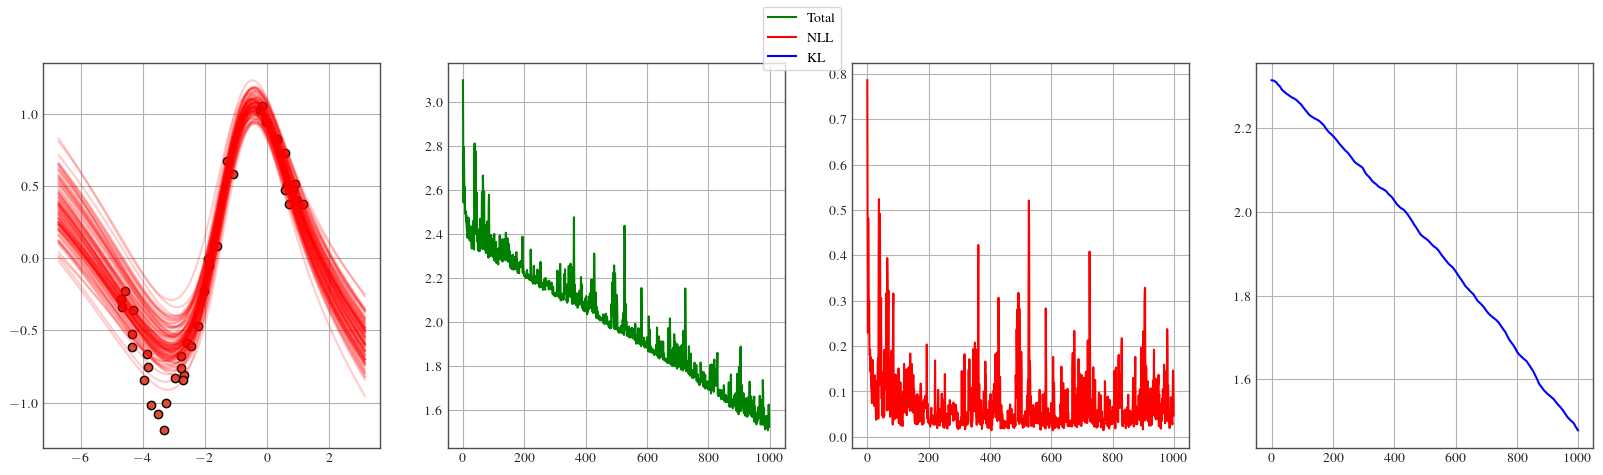

In [8]:
from dal_toolbox.models.variational_inference.trainer import VITrainer

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=32, shuffle=True)

model = Net(prior_sigma=1)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=0.9)

trainer = VITrainer(model, optimizer, criterion=nn.MSELoss(), kl_temperature=1)
train_stats = trainer.train(1000, train_loader)
train_history = train_stats['train_history']

fig = plt.figure(figsize=(20, 5))
axis = torch.linspace(X.min()-2, X.max()+2, 101)
with torch.no_grad():
    axis_pred = torch.stack([model(axis.view(-1, 1)).squeeze() for _ in range(100)], dim=-1)

plt.subplot(141)
plt.scatter(X, y)
plt.plot(axis, axis_pred, color='red', alpha=.2)
plt.subplot(142)
plt.plot([d['train_loss'] for d in train_history], label='Total', color='green')
plt.subplot(143)
plt.plot([d['train_nll'] for d in train_history], label='NLL', color='red')
plt.subplot(144)
plt.plot([d['train_kl_loss'] for d in train_history], label='KL', color='blue')
fig.legend(loc='upper center')
plt.show()


In [16]:
class BayesianCNN(nn.Module):
    def __init__(self, prior_sigma=1) -> None:
        super().__init__()
        self.conv1 = BayesianConv2d(1, 16, kernel_size=5, stride=2, prior_sigma=prior_sigma)
        self.conv2 = BayesianConv2d(16, 32, kernel_size=5, stride=2, prior_sigma=prior_sigma)
        self.l1 = BayesianLinear(512, 10, prior_sigma=prior_sigma)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, start_dim=1)
        out = self.l1(out)
        return out
        
class CNN(nn.Module):
    def __init__(self) -> None:
        super().__init__()

        self.conv1 = nn.Conv2d(1, 16, kernel_size=5, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2)
        self.l1 = nn.Linear(512, 10)

    def forward(self, x):
        out = self.conv1(x)
        out = self.conv2(out)
        out = torch.flatten(out, start_dim=1)
        out = self.l1(out)
        return out
        

Epoch [1] [  0/234] eta: 0:00:04 lr: 0.1 loss: 2.4113 (2.4113) nll: 2.3193 (2.3193) kl_loss: 0.0921 (0.0921) acc1: 5.0781 (5.0781) time: 0.0191 data: 0.0142 max mem: 14
Epoch [1] [200/234] eta: 0:00:00 lr: 0.1 loss: 0.4893 (0.6891) nll: 0.3728 (0.5670) kl_loss: 0.1142 (0.1221) acc1: 88.6719 (83.8075) time: 0.0169 data: 0.0127 max mem: 14
Epoch [1] Total time: 0:00:03
Epoch [2] [  0/234] eta: 0:00:04 lr: 0.1 loss: 0.5107 (0.5107) nll: 0.4005 (0.4005) kl_loss: 0.1102 (0.1102) acc1: 88.6719 (88.6719) time: 0.0183 data: 0.0145 max mem: 14
Epoch [2] [200/234] eta: 0:00:00 lr: 0.1 loss: 0.4474 (0.4617) nll: 0.3518 (0.3605) kl_loss: 0.0956 (0.1012) acc1: 90.2344 (89.5522) time: 0.0165 data: 0.0123 max mem: 14
Epoch [2] Total time: 0:00:03
Epoch [3] [  0/234] eta: 0:00:04 lr: 0.1 loss: 0.5004 (0.5004) nll: 0.4049 (0.4049) kl_loss: 0.0955 (0.0955) acc1: 87.5000 (87.5000) time: 0.0204 data: 0.0156 max mem: 14
Epoch [3] [200/234] eta: 0:00:00 lr: 0.1 loss: 0.4265 (0.4430) nll: 0.3372 (0.3514) kl_

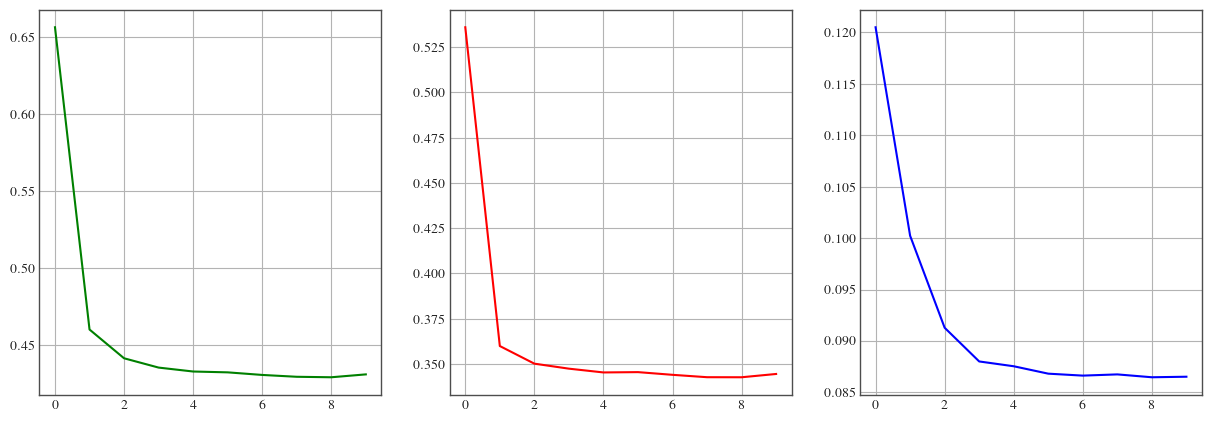

In [21]:
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

train_ds = MNIST('/tmp', True, transform=ToTensor(), download=True)
test_ds = MNIST('/tmp', False, transform=ToTensor(), download=True)

train_loader = torch.utils.data.DataLoader(train_ds, batch_size=256, shuffle=True, drop_last=True)
test_loader = torch.utils.data.DataLoader(test_ds, batch_size=256)

device='cuda'

model = BayesianCNN(prior_sigma=.005)
model.to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=.1, momentum=0.9)
trainer = VITrainer(model, optimizer, criterion=nn.CrossEntropyLoss(), device='cuda')
train_stats = trainer.train(10, train_loader)
train_history = train_stats['train_history']

plt.figure(figsize=(15, 5))
plt.subplot(131)
plt.plot([d['train_loss'] for d in train_history], label='Total', color='green')
plt.subplot(132)
plt.plot([d['train_nll'] for d in train_history], label='NLL', color='red')
plt.subplot(133)
plt.plot([d['train_kl_loss'] for d in train_history], label='KL', color='blue')
fig.legend(loc='upper center')
plt.show()

In [22]:
trainer.evaluate(test_loader)

{'test_loss': tensor(20.7995, device='cuda:0'),
 'test_acc1': 90.88999938964844,
 'test_nll': 0.3235330879688263,
 'test_brier': 0.14130078256130219,
 'test_tce': 0.029057297855615616,
 'test_mce': 0.025143271312117577}